In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Sequential, Input, layers, optimizers, regularizers, callbacks, losses, metrics 
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# FOR KAGGLE
train_images_dir = '../input/petfinder-pawpularity-score/train/'
test_images_dir = '../input/petfinder-pawpularity-score/test/'

# FOR LOCAL PC
# train_images_dir = './dataset/train/'
# test_images_dir = './dataset/test/'

In [4]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df.loc[:, 'filename'] = train_images_dir + train_df['Id'] + '.jpg'

test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df.loc[:, 'filename'] = test_images_dir + test_df['Id'] + '.jpg'

In [5]:
train_df.head(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,filename
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_df.loc[:, train_df.columns != 'Pawpularity'], train_df['Pawpularity'], test_size=0.2, random_state=42)

In [7]:
img_size = (320, 320, 3)
BATCH_SIZE = 32

def augment_image(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_hue(image, 0.05)
    return image, label

def parse_image(filename, label=None):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=img_size[2])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, img_size[:2])
    return image, label

def get_dataset(filenames, label=None, shuffle=False, augment=False, repeat=False):
    dataset = tf.data.TFRecordDataset.from_tensor_slices((filenames, label))     
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=4)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(True)
    return dataset

In [8]:
train_dataset = get_dataset(X_train['filename'], y_train, shuffle=True, augment=True)
val_dataset = get_dataset(X_val['filename'], y_val)
test_dataset = get_dataset(test_df['filename'])

2021-12-19 20:05:25.216085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:05:25.326115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:05:25.326825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 20:05:25.338093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
def build_model():
    model = Sequential([
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),      
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),      
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(258, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1)
    ])
    model.compile(optimizer=optimizers.Adam(), 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()]
                 )
    return model

es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.002, patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.000001)

In [10]:
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
#     steps_per_epoch=10,
#     use_multiprocessing=True,
#     callbacks=[es, reduce_lr]
)

Epoch 1/100


2021-12-19 20:05:28.995288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 20:05:39.248380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 892 of 1024
2021-12-19 20:05:40.582729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-12-19 20:05:41.810440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 112s 375ms/step - loss: 579.4182 - root_mean_squared_error: 24.0711 - val_loss: 461.7269 - val_root_mean_squared_error: 21.4878
Epoch 2/100
248/248 [==============================] - 92s 333ms/step - loss: 496.3818 - root_mean_squared_error: 22.2796 - val_loss: 442.7378 - val_root_mean_squared_error: 21.0413
Epoch 3/100
248/248 [==============================] - 90s 324ms/step - loss: 504.8375 - root_mean_squared_error: 22.4686 - val_loss: 454.3772 - val_root_mean_squared_error: 21.3161
Epoch 4/100
248/248 [==============================] - 87s 315ms/step - loss: 499.6631 - root_mean_squared_error: 22.3531 - val_loss: 448.1712 - val_root_mean_squared_error: 21.1701
Epoch 5/100
248/248 [==============================] - 90s 326ms/step - loss: 492.5910 - root_mean_squared_error: 22.1944 - val_loss: 473.1177 - val_root_mean_squared_error: 21.7513
Epoch 6/100
248/248 [==============================] - 92s 330ms/step - loss: 488.4208 - root_mean_sq

2021-12-19 20:31:29.084769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 971 of 1024
2021-12-19 20:31:29.500444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 331ms/step - loss: 480.7599 - root_mean_squared_error: 21.9262 - val_loss: 445.9574 - val_root_mean_squared_error: 21.1177
Epoch 14/100
248/248 [==============================] - 90s 329ms/step - loss: 481.5236 - root_mean_squared_error: 21.9436 - val_loss: 445.5953 - val_root_mean_squared_error: 21.1091
Epoch 15/100


2021-12-19 20:35:23.594684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 991 of 1024
2021-12-19 20:35:23.885645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 324ms/step - loss: 474.5423 - root_mean_squared_error: 21.7840 - val_loss: 443.8213 - val_root_mean_squared_error: 21.0671
Epoch 16/100
248/248 [==============================] - 93s 337ms/step - loss: 476.7423 - root_mean_squared_error: 21.8344 - val_loss: 449.1667 - val_root_mean_squared_error: 21.1936
Epoch 17/100
248/248 [==============================] - 94s 338ms/step - loss: 478.3229 - root_mean_squared_error: 21.8706 - val_loss: 501.2471 - val_root_mean_squared_error: 22.3885
Epoch 18/100
248/248 [==============================] - 94s 342ms/step - loss: 478.7625 - root_mean_squared_error: 21.8806 - val_loss: 445.9015 - val_root_mean_squared_error: 21.1164
Epoch 19/100


2021-12-19 20:44:03.078226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 982 of 1024
2021-12-19 20:44:03.547606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 336ms/step - loss: 474.3042 - root_mean_squared_error: 21.7785 - val_loss: 444.3696 - val_root_mean_squared_error: 21.0801
Epoch 20/100
248/248 [==============================] - 90s 324ms/step - loss: 482.1166 - root_mean_squared_error: 21.9572 - val_loss: 442.2357 - val_root_mean_squared_error: 21.0294
Epoch 21/100
248/248 [==============================] - 91s 326ms/step - loss: 473.0718 - root_mean_squared_error: 21.7502 - val_loss: 448.6133 - val_root_mean_squared_error: 21.1805
Epoch 22/100
248/248 [==============================] - 90s 329ms/step - loss: 473.5408 - root_mean_squared_error: 21.7610 - val_loss: 442.2787 - val_root_mean_squared_error: 21.0304
Epoch 23/100
248/248 [==============================] - 94s 340ms/step - loss: 473.9581 - root_mean_squared_error: 21.7706 - val_loss: 457.2372 - val_root_mean_squared_error: 21.3831
Epoch 24/100
248/248 [==============================] - 94s 344ms/step - loss: 471.5051 - root_mea

2021-12-19 20:58:10.244335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 996 of 1024
2021-12-19 20:58:10.554511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 331ms/step - loss: 473.7979 - root_mean_squared_error: 21.7669 - val_loss: 444.7381 - val_root_mean_squared_error: 21.0888
Epoch 27/100


2021-12-19 21:00:32.146448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 936 of 1024
2021-12-19 21:00:33.123154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 341ms/step - loss: 467.8179 - root_mean_squared_error: 21.6291 - val_loss: 453.8386 - val_root_mean_squared_error: 21.3035
Epoch 28/100


2021-12-19 21:02:54.074996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 974 of 1024
2021-12-19 21:02:54.487566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 330ms/step - loss: 475.7142 - root_mean_squared_error: 21.8109 - val_loss: 442.9559 - val_root_mean_squared_error: 21.0465
Epoch 29/100


2021-12-19 21:05:15.992484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 932 of 1024
2021-12-19 21:05:16.777421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 340ms/step - loss: 471.7023 - root_mean_squared_error: 21.7187 - val_loss: 445.2032 - val_root_mean_squared_error: 21.0998
Epoch 30/100
248/248 [==============================] - 91s 333ms/step - loss: 469.9768 - root_mean_squared_error: 21.6789 - val_loss: 444.5384 - val_root_mean_squared_error: 21.0841
Epoch 31/100


2021-12-19 21:09:13.063959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 959 of 1024
2021-12-19 21:09:13.593325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 325ms/step - loss: 471.8005 - root_mean_squared_error: 21.7210 - val_loss: 442.8589 - val_root_mean_squared_error: 21.0442
Epoch 32/100
248/248 [==============================] - 91s 330ms/step - loss: 464.6000 - root_mean_squared_error: 21.5546 - val_loss: 473.3536 - val_root_mean_squared_error: 21.7567
Epoch 33/100


2021-12-19 21:13:06.243698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1024
2021-12-19 21:13:06.906757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 341ms/step - loss: 468.7138 - root_mean_squared_error: 21.6498 - val_loss: 446.4199 - val_root_mean_squared_error: 21.1287
Epoch 34/100
248/248 [==============================] - 95s 347ms/step - loss: 470.2253 - root_mean_squared_error: 21.6847 - val_loss: 443.5686 - val_root_mean_squared_error: 21.0611
Epoch 35/100


2021-12-19 21:17:03.483607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 867 of 1024
2021-12-19 21:17:04.858817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 345ms/step - loss: 469.3278 - root_mean_squared_error: 21.6640 - val_loss: 443.9575 - val_root_mean_squared_error: 21.0703
Epoch 36/100
248/248 [==============================] - 96s 349ms/step - loss: 467.0056 - root_mean_squared_error: 21.6103 - val_loss: 447.1738 - val_root_mean_squared_error: 21.1465
Epoch 37/100
248/248 [==============================] - 94s 342ms/step - loss: 460.8084 - root_mean_squared_error: 21.4664 - val_loss: 452.6631 - val_root_mean_squared_error: 21.2759
Epoch 38/100


2021-12-19 21:21:50.364380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1024
2021-12-19 21:21:51.047257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 333ms/step - loss: 461.5403 - root_mean_squared_error: 21.4835 - val_loss: 442.3746 - val_root_mean_squared_error: 21.0327
Epoch 39/100
248/248 [==============================] - 94s 343ms/step - loss: 466.9629 - root_mean_squared_error: 21.6093 - val_loss: 447.4021 - val_root_mean_squared_error: 21.1519
Epoch 40/100


2021-12-19 21:24:57.756763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 925 of 1024
2021-12-19 21:24:58.620398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 346ms/step - loss: 463.2808 - root_mean_squared_error: 21.5240 - val_loss: 446.1045 - val_root_mean_squared_error: 21.1212
Epoch 41/100
248/248 [==============================] - 96s 351ms/step - loss: 459.9797 - root_mean_squared_error: 21.4471 - val_loss: 446.8396 - val_root_mean_squared_error: 21.1386
Epoch 42/100
248/248 [==============================] - 91s 330ms/step - loss: 459.0573 - root_mean_squared_error: 21.4256 - val_loss: 449.8099 - val_root_mean_squared_error: 21.2087
Epoch 43/100


2021-12-19 21:29:41.526020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 903 of 1024
2021-12-19 21:29:43.023912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 331ms/step - loss: 463.4279 - root_mean_squared_error: 21.5274 - val_loss: 446.9424 - val_root_mean_squared_error: 21.1410
Epoch 44/100


2021-12-19 21:32:03.437051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 898 of 1024
2021-12-19 21:32:04.515777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 334ms/step - loss: 463.8744 - root_mean_squared_error: 21.5377 - val_loss: 447.7233 - val_root_mean_squared_error: 21.1595
Epoch 45/100


2021-12-19 21:34:25.387843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:34:26.803020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 99s 351ms/step - loss: 462.5906 - root_mean_squared_error: 21.5079 - val_loss: 442.8743 - val_root_mean_squared_error: 21.0446
Epoch 46/100


2021-12-19 21:36:47.247798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 883 of 1024
2021-12-19 21:36:48.520646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 346ms/step - loss: 459.5693 - root_mean_squared_error: 21.4376 - val_loss: 445.3713 - val_root_mean_squared_error: 21.1038
Epoch 47/100
248/248 [==============================] - 92s 333ms/step - loss: 457.6452 - root_mean_squared_error: 21.3926 - val_loss: 442.8282 - val_root_mean_squared_error: 21.0435
Epoch 48/100


2021-12-19 21:39:56.058734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 905 of 1024
2021-12-19 21:39:57.027130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 334ms/step - loss: 459.8491 - root_mean_squared_error: 21.4441 - val_loss: 443.4232 - val_root_mean_squared_error: 21.0576
Epoch 49/100


2021-12-19 21:42:17.949117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 846 of 1024
2021-12-19 21:42:19.613908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 334ms/step - loss: 455.5188 - root_mean_squared_error: 21.3429 - val_loss: 442.3029 - val_root_mean_squared_error: 21.0310
Epoch 50/100


2021-12-19 21:44:39.862527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 783 of 1024
2021-12-19 21:44:41.895612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 345ms/step - loss: 456.6909 - root_mean_squared_error: 21.3703 - val_loss: 446.9092 - val_root_mean_squared_error: 21.1402
Epoch 51/100


2021-12-19 21:47:01.771523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 847 of 1024
2021-12-19 21:47:03.345569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 350ms/step - loss: 450.9922 - root_mean_squared_error: 21.2366 - val_loss: 442.9398 - val_root_mean_squared_error: 21.0461
Epoch 52/100


2021-12-19 21:49:23.696314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 858 of 1024
2021-12-19 21:49:25.104792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 350ms/step - loss: 452.0907 - root_mean_squared_error: 21.2624 - val_loss: 453.3739 - val_root_mean_squared_error: 21.2926
Epoch 53/100


2021-12-19 21:51:45.591449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 769 of 1024
2021-12-19 21:51:47.811258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 348ms/step - loss: 450.4728 - root_mean_squared_error: 21.2243 - val_loss: 443.0056 - val_root_mean_squared_error: 21.0477
Epoch 54/100


2021-12-19 21:54:07.520539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 887 of 1024
2021-12-19 21:54:08.619569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 342ms/step - loss: 447.0034 - root_mean_squared_error: 21.1425 - val_loss: 446.9254 - val_root_mean_squared_error: 21.1406
Epoch 55/100


2021-12-19 21:56:29.430710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 869 of 1024
2021-12-19 21:56:30.734895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 329ms/step - loss: 446.3220 - root_mean_squared_error: 21.1263 - val_loss: 442.0461 - val_root_mean_squared_error: 21.0249
Epoch 56/100


2021-12-19 21:58:51.347958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 768 of 1024
2021-12-19 21:58:53.519507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 91s 319ms/step - loss: 444.4913 - root_mean_squared_error: 21.0830 - val_loss: 442.6714 - val_root_mean_squared_error: 21.0398
Epoch 57/100


2021-12-19 22:01:13.246735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 881 of 1024
2021-12-19 22:01:14.818455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 334ms/step - loss: 443.9765 - root_mean_squared_error: 21.0707 - val_loss: 442.1805 - val_root_mean_squared_error: 21.0281
Epoch 58/100


2021-12-19 22:03:35.148623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 829 of 1024
2021-12-19 22:03:36.784266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 325ms/step - loss: 447.4557 - root_mean_squared_error: 21.1531 - val_loss: 442.2192 - val_root_mean_squared_error: 21.0290
Epoch 59/100
248/248 [==============================] - 90s 324ms/step - loss: 446.1133 - root_mean_squared_error: 21.1214 - val_loss: 442.7154 - val_root_mean_squared_error: 21.0408
Epoch 60/100
248/248 [==============================] - 88s 319ms/step - loss: 443.8426 - root_mean_squared_error: 21.0676 - val_loss: 442.0383 - val_root_mean_squared_error: 21.0247
Epoch 61/100
248/248 [==============================] - 94s 343ms/step - loss: 443.9712 - root_mean_squared_error: 21.0706 - val_loss: 442.0409 - val_root_mean_squared_error: 21.0248
Epoch 62/100
248/248 [==============================] - 98s 356ms/step - loss: 444.7503 - root_mean_squared_error: 21.0891 - val_loss: 442.0415 - val_root_mean_squared_error: 21.0248
Epoch 63/100
248/248 [==============================] - 96s 351ms/step - loss: 445.3019 - root_mea

2021-12-19 22:20:01.324133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 744 of 1024
2021-12-19 22:20:03.706630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 320ms/step - loss: 444.8109 - root_mean_squared_error: 21.0905 - val_loss: 442.0538 - val_root_mean_squared_error: 21.0251
Epoch 67/100


2021-12-19 22:22:23.215246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 799 of 1024
2021-12-19 22:22:25.113889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 323ms/step - loss: 445.3790 - root_mean_squared_error: 21.1040 - val_loss: 442.0386 - val_root_mean_squared_error: 21.0247
Epoch 68/100
248/248 [==============================] - 92s 334ms/step - loss: 449.5659 - root_mean_squared_error: 21.2030 - val_loss: 442.9035 - val_root_mean_squared_error: 21.0453
Epoch 69/100
248/248 [==============================] - 92s 332ms/step - loss: 448.3043 - root_mean_squared_error: 21.1732 - val_loss: 442.0598 - val_root_mean_squared_error: 21.0252
Epoch 70/100


2021-12-19 22:26:58.804740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 702 of 1024
2021-12-19 22:27:01.427160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 92s 320ms/step - loss: 444.3593 - root_mean_squared_error: 21.0798 - val_loss: 442.1563 - val_root_mean_squared_error: 21.0275
Epoch 71/100
248/248 [==============================] - 89s 322ms/step - loss: 444.8153 - root_mean_squared_error: 21.0906 - val_loss: 442.3919 - val_root_mean_squared_error: 21.0331
Epoch 72/100


2021-12-19 22:30:52.683188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 703 of 1024
2021-12-19 22:30:55.265666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 333ms/step - loss: 442.2442 - root_mean_squared_error: 21.0296 - val_loss: 444.8086 - val_root_mean_squared_error: 21.0905
Epoch 73/100


2021-12-19 22:33:14.596451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 752 of 1024
2021-12-19 22:33:16.941250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 96s 338ms/step - loss: 445.1859 - root_mean_squared_error: 21.0994 - val_loss: 442.5575 - val_root_mean_squared_error: 21.0371
Epoch 74/100


2021-12-19 22:35:36.509609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 682 of 1024
2021-12-19 22:35:39.471341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 326ms/step - loss: 443.5016 - root_mean_squared_error: 21.0595 - val_loss: 442.2401 - val_root_mean_squared_error: 21.0295
Epoch 75/100


2021-12-19 22:37:58.424567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 697 of 1024
2021-12-19 22:38:01.142681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 327ms/step - loss: 439.4272 - root_mean_squared_error: 20.9625 - val_loss: 443.0339 - val_root_mean_squared_error: 21.0484
Epoch 76/100


2021-12-19 22:40:20.351717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 684 of 1024
2021-12-19 22:40:23.203099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 93s 321ms/step - loss: 439.9179 - root_mean_squared_error: 20.9742 - val_loss: 443.0526 - val_root_mean_squared_error: 21.0488
Epoch 77/100
248/248 [==============================] - 90s 329ms/step - loss: 442.7193 - root_mean_squared_error: 21.0409 - val_loss: 443.4631 - val_root_mean_squared_error: 21.0586
Epoch 78/100
248/248 [==============================] - 92s 338ms/step - loss: 444.1428 - root_mean_squared_error: 21.0747 - val_loss: 442.3869 - val_root_mean_squared_error: 21.0330
Epoch 79/100
248/248 [==============================] - 97s 355ms/step - loss: 443.9191 - root_mean_squared_error: 21.0694 - val_loss: 442.2502 - val_root_mean_squared_error: 21.0297
Epoch 80/100
248/248 [==============================] - 93s 338ms/step - loss: 441.1926 - root_mean_squared_error: 21.0046 - val_loss: 442.0401 - val_root_mean_squared_error: 21.0247
Epoch 81/100


2021-12-19 22:48:54.576179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 710 of 1024
2021-12-19 22:48:57.423572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 327ms/step - loss: 439.7643 - root_mean_squared_error: 20.9706 - val_loss: 442.0991 - val_root_mean_squared_error: 21.0262
Epoch 82/100
248/248 [==============================] - 93s 339ms/step - loss: 441.8686 - root_mean_squared_error: 21.0207 - val_loss: 442.3083 - val_root_mean_squared_error: 21.0311
Epoch 83/100


2021-12-19 22:52:50.454429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 637 of 1024
2021-12-19 22:52:53.949171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 341ms/step - loss: 442.1095 - root_mean_squared_error: 21.0264 - val_loss: 442.1328 - val_root_mean_squared_error: 21.0270
Epoch 84/100
248/248 [==============================] - 94s 338ms/step - loss: 445.7229 - root_mean_squared_error: 21.1122 - val_loss: 446.1708 - val_root_mean_squared_error: 21.1228
Epoch 85/100


2021-12-19 22:56:50.534363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 690 of 1024
2021-12-19 22:56:53.518073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 95s 331ms/step - loss: 442.4211 - root_mean_squared_error: 21.0338 - val_loss: 443.6956 - val_root_mean_squared_error: 21.0641
Epoch 86/100
248/248 [==============================] - 93s 341ms/step - loss: 444.2682 - root_mean_squared_error: 21.0777 - val_loss: 442.1086 - val_root_mean_squared_error: 21.0264
Epoch 87/100


2021-12-19 23:00:47.671198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 695 of 1024
2021-12-19 23:00:51.469756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 336ms/step - loss: 442.7730 - root_mean_squared_error: 21.0422 - val_loss: 442.0756 - val_root_mean_squared_error: 21.0256
Epoch 88/100
248/248 [==============================] - 90s 328ms/step - loss: 446.0881 - root_mean_squared_error: 21.1208 - val_loss: 442.0406 - val_root_mean_squared_error: 21.0248
Epoch 89/100


2021-12-19 23:04:39.693194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 664 of 1024
2021-12-19 23:04:43.250234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 339ms/step - loss: 444.5704 - root_mean_squared_error: 21.0848 - val_loss: 442.0358 - val_root_mean_squared_error: 21.0246
Epoch 90/100
248/248 [==============================] - 94s 340ms/step - loss: 442.0992 - root_mean_squared_error: 21.0262 - val_loss: 442.4646 - val_root_mean_squared_error: 21.0348
Epoch 91/100
248/248 [==============================] - 93s 340ms/step - loss: 444.6512 - root_mean_squared_error: 21.0868 - val_loss: 442.1196 - val_root_mean_squared_error: 21.0266
Epoch 92/100
248/248 [==============================] - 91s 330ms/step - loss: 442.2792 - root_mean_squared_error: 21.0304 - val_loss: 442.0593 - val_root_mean_squared_error: 21.0252
Epoch 93/100


2021-12-19 23:10:55.172308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 691 of 1024
2021-12-19 23:10:58.458766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 94s 326ms/step - loss: 442.4044 - root_mean_squared_error: 21.0334 - val_loss: 442.5616 - val_root_mean_squared_error: 21.0371
Epoch 94/100
248/248 [==============================] - 90s 328ms/step - loss: 440.4351 - root_mean_squared_error: 20.9865 - val_loss: 443.9983 - val_root_mean_squared_error: 21.0713
Epoch 95/100
248/248 [==============================] - 94s 346ms/step - loss: 438.9262 - root_mean_squared_error: 20.9506 - val_loss: 443.0959 - val_root_mean_squared_error: 21.0498
Epoch 96/100


2021-12-19 23:16:21.660331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 710 of 1024
2021-12-19 23:16:25.223429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 98s 340ms/step - loss: 443.2605 - root_mean_squared_error: 21.0538 - val_loss: 442.5385 - val_root_mean_squared_error: 21.0366
Epoch 97/100
248/248 [==============================] - 93s 340ms/step - loss: 442.6173 - root_mean_squared_error: 21.0385 - val_loss: 443.3288 - val_root_mean_squared_error: 21.0554
Epoch 98/100


2021-12-19 23:20:21.596894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 668 of 1024
2021-12-19 23:20:25.434585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


248/248 [==============================] - 97s 337ms/step - loss: 446.1218 - root_mean_squared_error: 21.1216 - val_loss: 443.7914 - val_root_mean_squared_error: 21.0664
Epoch 99/100
248/248 [==============================] - 90s 327ms/step - loss: 440.5566 - root_mean_squared_error: 20.9894 - val_loss: 443.1635 - val_root_mean_squared_error: 21.0514
Epoch 100/100
248/248 [==============================] - 91s 330ms/step - loss: 443.2978 - root_mean_squared_error: 21.0546 - val_loss: 442.6559 - val_root_mean_squared_error: 21.0394


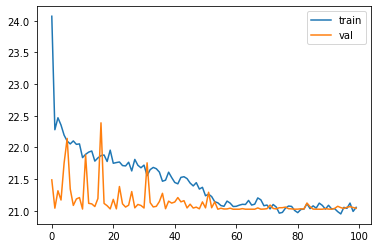

In [11]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

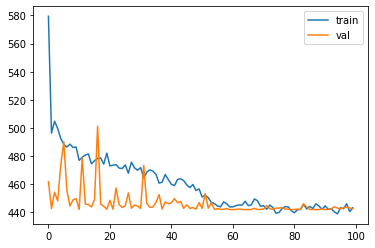

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [13]:
preds = model.predict(test_dataset)

In [14]:
submisson_df = test_df[['Id']]
submisson_df['Pawpularity'] = preds

In [15]:
submisson_df

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.262928
1,43a2262d7738e3d420d453815151079e,37.262928
2,4e429cead1848a298432a0acad014c9d,37.262928
3,80bc3ccafcc51b66303c2c263aa38486,37.262928
4,8f49844c382931444e68dffbe20228f4,37.262928
5,b03f7041962238a7c9d6537e22f9b017,37.262928
6,c978013571258ed6d4637f6e8cc9d6a3,37.262928
7,e0de453c1bffc20c22b072b34b54e50f,37.262928


In [16]:
submisson_df.to_csv('submission.csv', index=False)

In [17]:
model.save('/kaggle/working/cnn_images_only_model.h5')